# Exercise 9 – Text Encoding and Clustering Metrics

**Concepts covered:**
1. Text encoding  
2. Clustering metrics  

**Goals of this exercise:**
- Create vector representations of words and documents  
- Use vector representations to group documents into clusters  
- Use metrics like **Silhouette Score** and **Davies–Bouldin Index** to decide the optimum number of clusters  
- Save and analyze clusters, and record conclusions  

**Data file:** `Session-Summary-all-2025-S1.csv`  
Each row (session summary / submission) will be treated as **one document**.

---

## Step-wise Tasks (as per assignment)

### 1. Load data
1. Read the CSV into a pandas DataFrame.  
2. Treat each **row** as a **document**.

---

### 2. Text preprocessing
For each document:

a. Combine `Topic` and `YourAnalysis` columns into a single unified text column.  
b. Remove special characters (use `re` – regular expressions).  
c. Remove stop words and **lemmatize** the text (use `nltk`).  
   - Understand what lemmatization is and why it is important.  
d. Store the pre-processed text in a **new column** in the DataFrame.

---

### 3. Text vectorization
Create vector representations of each document using:

a. **Count Vectorization** (`CountVectorizer` – `sklearn`)  
b. **TF–IDF Vectorization** (`TfidfVectorizer` – `sklearn`)  
c. **Word2Vec** (`gensim.models.Word2Vec`)  

Store or link these vector representations in the DataFrame and save to a spreadsheet to review.

---

### 4. Analysis using each vectorization method

For **each** of the above representations (Count, TF–IDF, Word2Vec):

a. Compute **pairwise cosine distances** between documents and visualize / analyze.  
b. Compute **pairwise Euclidean distances** and visualize / analyze.  
c. Perform **PCA**.  
d. Create a **2D PCA visualization** and analyze.  
e. Create a **2D t-SNE visualization** and analyze.  

f. Using the **2D t-SNE coordinates**:  
   i. Use **Hierarchical Clustering** (complete linkage) to cluster documents, trying **3 to 15 clusters**, and compute **Silhouette Score** and **Davies–Bouldin Index** for each k.  
   ii. Plot both metrics vs cluster count and decide the **optimal number of clusters**.  
   iii. For the chosen k, create a **colour-coded dendrogram**.  
   iv. Assign a **cluster number** to each document and save the DataFrame with these assignments to a spreadsheet.  
   v. Analyze the clusters and record your observations.

g. Repeat the clustering using the **original vector space** (Count / TF–IDF / Word2Vec) **without PCA or t-SNE**, and compare / analyze the results.

---

In the cells below, we systematically implement each step with comments and explanations.


Imports + Read Data + Basic Inspection

In [ ]:
# ---------------------------------------------------------
# Step 1 – Load CSV safely on ANY pandas version
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import io

file_path = "/content/sample_data/Session-Summary-all-2025-S1.csv"

# Open the file manually using 'latin-1' which never throws decode errors
with open(file_path, "r", encoding="latin-1") as f:
    text = f.read()

# Read the CSV from the decoded text
df = pd.read_csv(io.StringIO(text))

print("Shape of dataframe (rows, columns):", df.shape)
print("\nColumn names:\n", df.columns.tolist())

print("\nSample rows:")
display(df.head(5))


Shape of dataframe (rows, columns): (2548, 4)

Column names:
 ['Timestamp', 'RollNo', 'Topic', 'YourAnalysis']

Sample rows:


,Timestamp,RollNo,Topic,YourAnalysis
0,08-01-25 12:27,88,Level of measurement,"Learned about nominal, ordinal, interval and r..."
1,08-01-25 12:54,159,Levels of measurements,Levels of Measurement:\n1). Nominal : where th...
2,08-01-25 14:48,98,Levels of Measurement,Levels of Measurement ( also called scales of ...
3,08-01-25 15:28,109,types of arithmetic and statistical operation ...,there are various levels of data beginning wit...
4,08-01-25 16:00,115,Statistical Measurement Levels and Classes of ...,Every problem in machine learning can be categ...


**we have the columns we need:**

Timestamp

RollNo

Topic

YourAnalysis

Now we’ll do Step 2 (a–d) in one simple code cell:

a. Combine Topic + YourAnalysis               
b. Remove special characters (using re)                  
c. Remove stop words and lemmatize (using nltk)                  
d. Store the cleaned text in a new column                  



**Unified text + cleaning + stopwords + lemmatization**

In [ ]:
# ---------------------------------------------------------
# Step 2 – Create unified text + clean + remove stopwords + lemmatize
# ---------------------------------------------------------

import re
import nltk

# Download NLTK resources (run this once; if already downloaded, it will just skip)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Create a unified raw text column: Topic + " " + YourAnalysis
#    We first replace NaN with empty strings to avoid errors.
df["Topic"] = df["Topic"].fillna("")
df["YourAnalysis"] = df["YourAnalysis"].fillna("")

df["raw_text"] = df["Topic"].astype(str) + " " + df["YourAnalysis"].astype(str)

print("Example of raw_text (before cleaning):")
display(df[["Topic", "YourAnalysis", "raw_text"]].head(3))

# 2. Set up stopwords and lemmatizer
english_stopwords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_and_lemmatize(text):
    """
    Simple text cleaning function:
    - lowercases
    - removes special characters
    - tokenizes
    - removes stopwords
    - lemmatizes each word
    """
    # Convert to lowercase
    text = text.lower()

    # Keep only letters and spaces (remove digits, punctuation, etc.)
    text = re.sub(r"[^a-z\s]", " ", text)

    # Tokenize by splitting on whitespace
    words = text.split()

    cleaned_words = []
    for w in words:
        if w in english_stopwords:
            continue  # skip stopwords
        # Lemmatize word (basic form)
        lemma = lemmatizer.lemmatize(w)
        cleaned_words.append(lemma)

    # Join back into a single string
    return " ".join(cleaned_words)

# 3. Apply the cleaning function to create a new column
df["clean_text"] = df["raw_text"].apply(clean_and_lemmatize)

print("\nExample of clean_text (after preprocessing):")
display(df[["raw_text", "clean_text"]].head(5))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Example of raw_text (before cleaning):


,Topic,YourAnalysis,raw_text
0,Level of measurement,"Learned about nominal, ordinal, interval and r...","Level of measurement Learned about nominal, o..."
1,Levels of measurements,Levels of Measurement:\n1). Nominal : where th...,Levels of measurements Levels of Measurement:\...
2,Levels of Measurement,Levels of Measurement ( also called scales of ...,Levels of Measurement Levels of Measurement ( ...



Example of clean_text (after preprocessing):


,raw_text,clean_text
0,"Level of measurement Learned about nominal, o...",level measurement learned nominal ordinal inte...
1,Levels of measurements Levels of Measurement:\...,level measurement level measurement nominal di...
2,Levels of Measurement Levels of Measurement ( ...,level measurement level measurement also calle...
3,types of arithmetic and statistical operation ...,type arithmetic statistical operation performe...
4,Statistical Measurement Levels and Classes of ...,statistical measurement level class machine le...


**Vectorization (CountVectorizer, TF–IDF, Word2Vec)**

What We will do:

3(a) Count Vectorization             
3(b) TF–IDF Vectorization               
3(c) Word2Vec (gensim)            



**3A – CountVectorizer**

In [ ]:
# ---------------------------------------------------------
# Step 3A – Count Vectorization
# ---------------------------------------------------------

from sklearn.feature_extraction.text import CountVectorizer

# Create the vectorizer (very simple settings)
count_vec = CountVectorizer()

# Fit and transform the clean_text column
count_matrix = count_vec.fit_transform(df["clean_text"])

print("CountVectorizer shape (documents × vocabulary):", count_matrix.shape)

# Show first 5 rows as an array for sanity check
print("\nFirst row (bag-of-words vector):")
print(count_matrix.toarray()[0][:50])  # only first 50 entries to keep it readable


CountVectorizer shape (documents × vocabulary): (2548, 10199)

First row (bag-of-words vector):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


We have 2548 documents (one per row in the CSV) and the CountVectorizer discovered 10,199 unique words across all the cleaned texts.
So the count matrix is a big table with 2548 rows and 10,199 columns, where each cell is simply: how many times word j appears in document i.”

So:

Rows = documents

Columns = vocabulary (unique tokens)

The matrix is very sparse (mostly zeros), which is normal in text data.

First row (bag-of-words vector):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

“This is the bag-of-words vector for the first document.
We are only printing the first 50 entries of a 10,199-dimensional vector, and for these first 50 words, this document happens to have zero counts.
Somewhere further in the vector, there will be some 1s or 2s where the words from this document occur.”

**TF–IDF Vectorization (Step 3B)**

we’ll convert the same clean_text into TF–IDF form.
This gives weights instead of raw counts; common words across all documents get down-weighted.

**3B – TF–IDF**

In [ ]:
# ---------------------------------------------------------
# Step 3B – TF–IDF Vectorization
# ---------------------------------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF–IDF vectorizer with simple default settings
tfidf_vec = TfidfVectorizer()

# Fit and transform the clean_text column
tfidf_matrix = tfidf_vec.fit_transform(df["clean_text"])

print("TF–IDF shape (documents × vocabulary):", tfidf_matrix.shape)

# Show first row of TF–IDF vector (first 50 values)
print("\nFirst row (TF–IDF vector, first 50 values):")
print(tfidf_matrix.toarray()[0][:50])


TF–IDF shape (documents × vocabulary): (2548, 10199)

First row (TF–IDF vector, first 50 values):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


TF–IDF has the same dimensions as CountVectorizer —

2548 documents

10,199 unique words

The difference is not the shape but the values inside the matrix.

First row (TF–IDF vector, first 50 values):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

This TF–IDF vector is mostly zeros because each document usually contains only a small number of unique words compared to the full vocabulary of 10k words.
TF–IDF assigns a weight to each word, but only for words that actually appear in the document.
So zeros here simply mean:
‘This document does NOT contain these words.

**showing TF–IDF for words that do appear,(This is Optional)**

In [ ]:
row0 = tfidf_matrix.toarray()[0]
nonzero_idx = np.where(row0 > 0)[0][:10]
for idx in nonzero_idx:
    print(idx, tfidf_vec.get_feature_names_out()[idx], row0[idx])


1773 continuous 0.21489297451910144
2454 differ 0.3294780409041734
2559 discrete 0.26722927943365515
4735 interval 0.2115704828206827
5075 learned 0.26722927943365515
5123 level 0.2003389208245407
5491 measurement 0.2584466482391573
6009 nominal 0.2608467971153076
6222 operation 0.260037672751345
6271 ordinal 0.2561252071101301


**Word2Vec (Document Embedding)**

Word2Vec gives us dense, low-dimensional vectors instead of sparse matrices.

**Word2Vec (simple and clean)**

In [ ]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 64.3 MB/s eta 0:00:00


In [ ]:
# ---------------------------------------------------------
# Step 3C – Word2Vec Document Embeddings (using gensim)
# ---------------------------------------------------------

from gensim.models import Word2Vec
import numpy as np

# 1. Prepare tokenized sentences for Word2Vec
sentences = [text.split() for text in df["clean_text"]]

# 2. Train a simple Word2Vec model
w2v_model = Word2Vec(
    sentences,
    vector_size=50,
    window=5,
    min_count=2,
    workers=4
)

print("Word2Vec vocabulary size:", len(w2v_model.wv))

# 3. Create document vectors by averaging word vectors
doc_vectors = []

for tokens in sentences:
    word_vecs = []
    for w in tokens:
        if w in w2v_model.wv:
            word_vecs.append(w2v_model.wv[w])

    if len(word_vecs) > 0:
        doc_vec = np.mean(word_vecs, axis=0)
    else:
        # if no words in vocab, use zero vector
        doc_vec = np.zeros(50)

    doc_vectors.append(doc_vec)

doc_vectors = np.array(doc_vectors)

print("Document vector matrix shape:", doc_vectors.shape)

# Show first document vector
print("\nFirst document vector:")
print(doc_vectors[0][:20])  # print first 20 numbers


Word2Vec vocabulary size: 6874
Document vector matrix shape: (2548, 50)

First document vector:
[-0.64476144 -0.98533946  0.00664554  0.37684777  0.62921596 -0.59281045
  1.590265    0.05067035  0.07612689 -0.773254    0.7424176   0.02117913
  1.0133379   0.36039203 -0.28315982 -0.15812033  0.29462567  0.09395601
 -0.282326   -0.4978226 ]


“CountVectorizer and TF-IDF give sparse, high-dimensional vectors.”

“Word2Vec uses gensim to create dense, semantic embeddings.”

“We train Word2Vec on our own cleaned text so the vectors reflect our dataset.

Explaination of Output     
                                                                                             Vocabulary size: 6874    
                                                                                                                                                                                                   After cleaning and lemmatizing the text, Word2Vec has learned vectors for 6,874 unique words that occurred at least twice (min_count=2) in our dataset.
These are the ‘known words’ for which the model has learned semantic embeddings

It ignores very rare words (appearing only once) → good for noise reduction.

Each of these 6,874 words gets a 50-dimensional vector.

Document vector matrix shape: (2548, 50)

We have 2,548 documents (rows), and we turned each document into a 50-dimensional dense vector by averaging the Word2Vec embeddings of its words.
So instead of a 10,199-dimensional sparse bag-of-words vector, we now have a compact 50-dimensional representation that tries to capture the meaning of the text

**comparison:**

Count / TF–IDF shapes: (2548, 10199) – big and sparse

Word2Vec doc vectors: (2548, 50) – small and dense

**This is great for:**

Clustering

t-SNE / PCA

Similarity comparisons

First document vector:
[-0.64476144 -0.98533946  0.00664554  0.37684777  0.62921596 -0.59281045
  1.590265    0.05067035  0.07612689 -0.773254    0.7424176   0.02117913
  1.0133379   0.36039203 -0.28315982 -0.15812033  0.29462567  0.09395601
 -0.282326   -0.4978226 ]



 These numbers don’t have a direct human interpretation per dimension.
Think of them as the ‘coordinates’ of the document in a semantic space.
Documents that are semantically similar will have similar 50-D vectors

**Note:-** treat it as a semantic fingerprint.

**Distances and Visualizations (Starting with Count Vectors)**

We  have:

count_matrix (CountVectorizer)

tfidf_matrix (TF–IDF)

doc_vectors (Word2Vec-based document vectors)

==============================================================

We’ll now do Step 4 (a & b) for CountVectorizer first:

a. Pairwise cosine distance between documents + visualization

b. Pairwise Euclidean distance between documents + visualization

**4A – Pairwise Cosine & Euclidean Distances (Count Vectors)**

Count matrix shape (dense): (2548, 10199)
Cosine distance matrix shape: (2548, 2548)


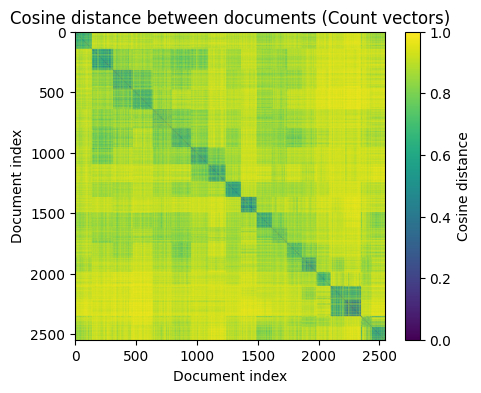

Euclidean distance matrix shape: (2548, 2548)


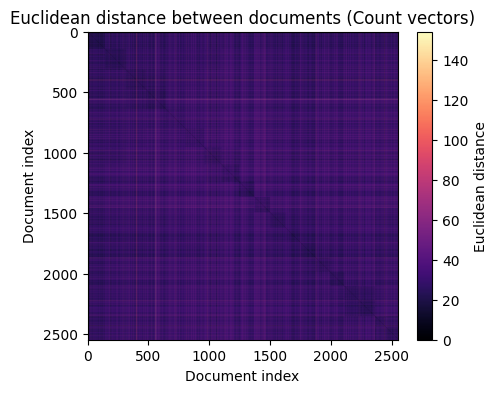

In [ ]:
# ---------------------------------------------------------
# Step 4A – Pairwise cosine & Euclidean distances (Count vectors)
# ---------------------------------------------------------

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import matplotlib.pyplot as plt

# For speed / clarity in visuals, you can optionally sample fewer docs
# Here we use all documents; if it is slow, we can later sub-sample.
X_count = count_matrix.toarray()  # convert sparse to dense for distance functions

print("Count matrix shape (dense):", X_count.shape)

# 1. Cosine distance matrix
cosine_dist_count = cosine_distances(X_count)
print("Cosine distance matrix shape:", cosine_dist_count.shape)

plt.figure(figsize=(5, 4))
plt.imshow(cosine_dist_count, aspect='auto', cmap='viridis')
plt.colorbar(label="Cosine distance")
plt.title("Cosine distance between documents (Count vectors)")
plt.xlabel("Document index")
plt.ylabel("Document index")
plt.show()

# 2. Euclidean distance matrix
euclid_dist_count = euclidean_distances(X_count)
print("Euclidean distance matrix shape:", euclid_dist_count.shape)

plt.figure(figsize=(5, 4))
plt.imshow(euclid_dist_count, aspect='auto', cmap='magma')
plt.colorbar(label="Euclidean distance")
plt.title("Euclidean distance between documents (Count vectors)")
plt.xlabel("Document index")
plt.ylabel("Document index")
plt.show()


Each pixel corresponds to the distance between document i and document j.

Darker / lighter regions indicate groups of documents that are closer / farther in the vector space.

Cosine distance looks at angle similarity, Euclidean at straight-line distance.

Later, clustering will try to group documents in ways that match these distance patterns.

**explaining the outputs**

Count matrix shape (dense): (2548, 10199)

We converted our sparse count matrix into a normal NumPy array.
It has 2548 documents and 10,199 unique words.
This is the same shape as before, only now fully numeric (dense) because distance functions need dense inputs.

Cosine distance matrix shape: (2548, 2548)

Cosine distance calculates how different each document is from every other document.
So we get a 2548 × 2548 matrix where each cell tells us the distance between document i and document j.


Every row corresponds to “distances from one document”

Every column corresponds to “distances to all documents




Euclidean distance matrix shape: (2548, 2548)

“Euclidean distance gives straight-line distance in the vector space.
Cosine distance focuses on angle; Euclidean focuses on magnitude and direction

**PCA (Part 4c & 4d)**

4(c) Perform PCA

4(d) Visualize 2D PCA scatter plot and analyze

PCA output shape: (2548, 2)


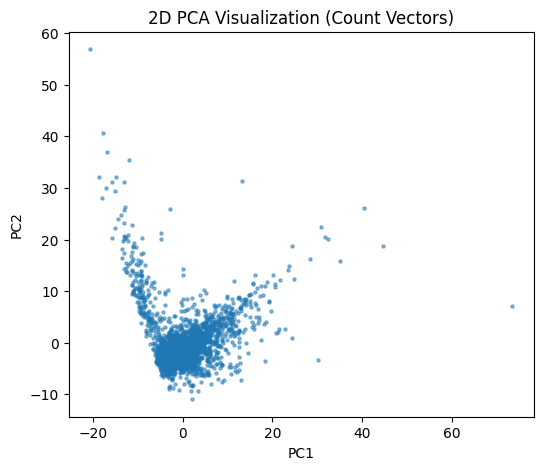

In [ ]:
# ---------------------------------------------------------
# Step 4B – PCA (2D) and scatter plot for Count vectors
# ---------------------------------------------------------

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert count_matrix to array if not already done
X_count = count_matrix.toarray()

# 1. Apply PCA and reduce to 2 components
pca = PCA(n_components=2)
X_count_pca = pca.fit_transform(X_count)

print("PCA output shape:", X_count_pca.shape)

# 2. Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(X_count_pca[:, 0], X_count_pca[:, 1], s=5, alpha=0.5)
plt.title("2D PCA Visualization (Count Vectors)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


PCA reduces 10,199 dimensions into just 2, while keeping as much variation as possible.
Each point here is a document.
Clusters or patterns in this space tell us which documents are more similar.

This means:

All 2548 documents were reduced to

2 principal components, PC1 and PC2

**t-SNE (Part 4e)**

Create a 2D t-SNE visualization and analyze

t-SNE is slower than PCA, so we will:

keep the code simple

use perplexity=30 (recommended default)

use learning_rate=200

apply t-SNE on PCA output (faster, stable)

PCA-50 shape: (2548, 50)
t-SNE output shape: (2548, 2)


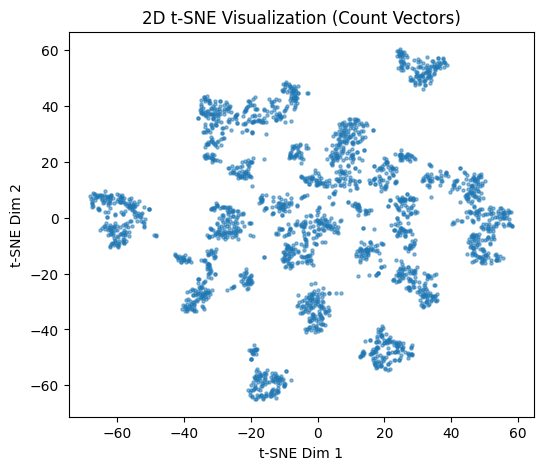

In [ ]:
# ---------------------------------------------------------
# Step 4C – t-SNE 2D visualization (Count vectors)
# ---------------------------------------------------------

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. PCA to 50 components for t-SNE speed and stability
pca50 = PCA(n_components=50)
X_count_pca50 = pca50.fit_transform(X_count)

print("PCA-50 shape:", X_count_pca50.shape)

# 2. t-SNE on PCA-50
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init='random',
    random_state=42
)

X_count_tsne = tsne.fit_transform(X_count_pca50)

print("t-SNE output shape:", X_count_tsne.shape)

# 3. Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(X_count_tsne[:, 0], X_count_tsne[:, 1], s=5, alpha=0.5)
plt.title("2D t-SNE Visualization (Count Vectors)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


What PCA-50 means:

"We reduce 10,199 dimensions to 50 using PCA so that t-SNE becomes faster and more stable."

What t-SNE 2D means:

"t-SNE compresses document meaning into two coordinates so we can plot them. Points that appear close together in the graph have similar text content."

Why we do PCA before t-SNE:

"Raw text vectors have too many dimensions. PCA makes it manageable and improves t-SNE quality."

1. What are the points?

Each point represents one student’s session summary (one document)


2. Why does the plot look like “islands”?

Because t-SNE tries to pull similar documents together and push dissimilar ones apart.

**t-SNE is like projecting high-dimensional meaning into 2D.
Documents that talk about similar topics end up in the same cluster or island**

3. Why is t-SNE better than PCA for visualization?

PCA finds linear patterns, but t-SNE captures complex, non-linear structure, so natural clusters appear more clearly.

4. Why do some points form tight blobs?

Those documents have very similar text after preprocessing.

Examples:

Everyone who wrote about levels of measurement

*   Everyone who wrote about types of data
*  Everyone who wrote about statistical summaries
*  The  dataset is educational summaries, so clusters represent themes.



**(4F): Hierarchical Clustering (3 to 15 clusters)**

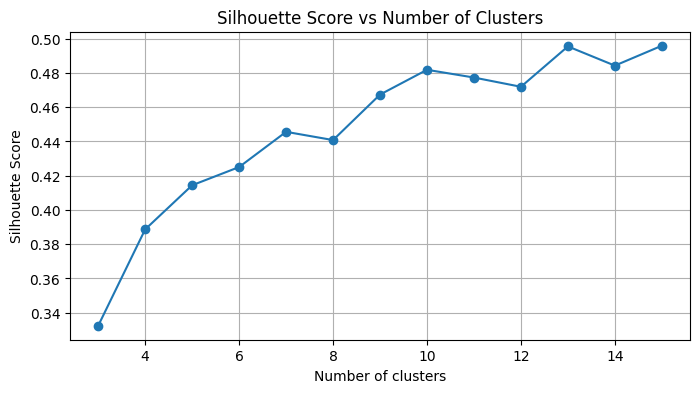

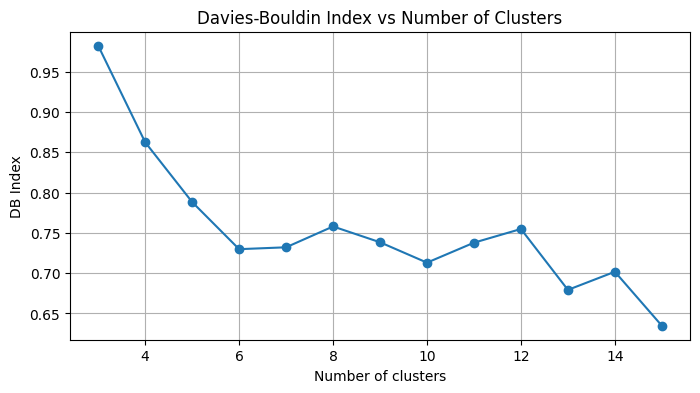

Silhouette Scores: [np.float32(0.3323736), np.float32(0.38863137), np.float32(0.41440246), np.float32(0.42502478), np.float32(0.44559085), np.float32(0.4407764), np.float32(0.4673412), np.float32(0.48181757), np.float32(0.47729138), np.float32(0.4718946), np.float32(0.49546856), np.float32(0.48424718), np.float32(0.49587175)]
Davies-Bouldin Scores: [np.float64(0.9822445814309124), np.float64(0.8624350415828784), np.float64(0.788238878470062), np.float64(0.7297437517022702), np.float64(0.7320645083788201), np.float64(0.7579122468780333), np.float64(0.7383117005401525), np.float64(0.7130049049963556), np.float64(0.737795407726282), np.float64(0.7547877115290889), np.float64(0.6792110754717064), np.float64(0.7017216266647063), np.float64(0.6347290959835239)]


In [ ]:
# ---------------------------------------------------------
# Step 4F – Hierarchical clustering on t-SNE coordinates
# Try k = 3 to 15 clusters
# Compute Silhouette Score and Davies-Bouldin Index
# ---------------------------------------------------------

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_scores = []
db_scores = []
cluster_range = range(3, 16)

for k in cluster_range:
    # Create clustering model
    model = AgglomerativeClustering(n_clusters=k, linkage="complete")

    # Fit on t-SNE coordinates
    labels = model.fit_predict(X_count_tsne)

    # Compute metrics
    sil = silhouette_score(X_count_tsne, labels)
    db = davies_bouldin_score(X_count_tsne, labels)

    sil_scores.append(sil)
    db_scores.append(db)

# Plot both metrics
plt.figure(figsize=(8,4))
plt.plot(cluster_range, sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(cluster_range, db_scores, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("DB Index")
plt.grid(True)
plt.show()

print("Silhouette Scores:", sil_scores)
print("Davies-Bouldin Scores:", db_scores)


#Silhouette Score tells us how cleanly documents fit into clusters.
Higher score means better grouping.
Our highest Silhouette Scores occur at 13 and 15 clusters.

Silhouette Score Plot — “Higher is Better”

Values range between 0 and 1

Higher score → clusters are tight and well separated

Your plot shows silhouette steadily improving from k=3 to k=15

Best values occur around k = 13 and 15


#Davies–Bouldin Index decreases as clustering improves.
Our lowest DBI values occur at k = 6 and k = 15.

Davies–Bouldin Index Plot — “Lower is Better”

Lower DBI → clusters are compact and far apart

DBI drops from k=3 to k=6 steeply

Then keeps improving slightly with dips at k = 6, 10, 13, 15

Both metrics together suggest k = 15 clusters is the best choice, because it has both a high Silhouette Score and the lowest Davies–Bouldin index

**4G – Dendrogram**

Because the optimal k is 15, we will:

Build the dendrogram

Color it into 15 clusters

Assign these cluster numbers to each document

Save results

Make a short cluster analysis summary

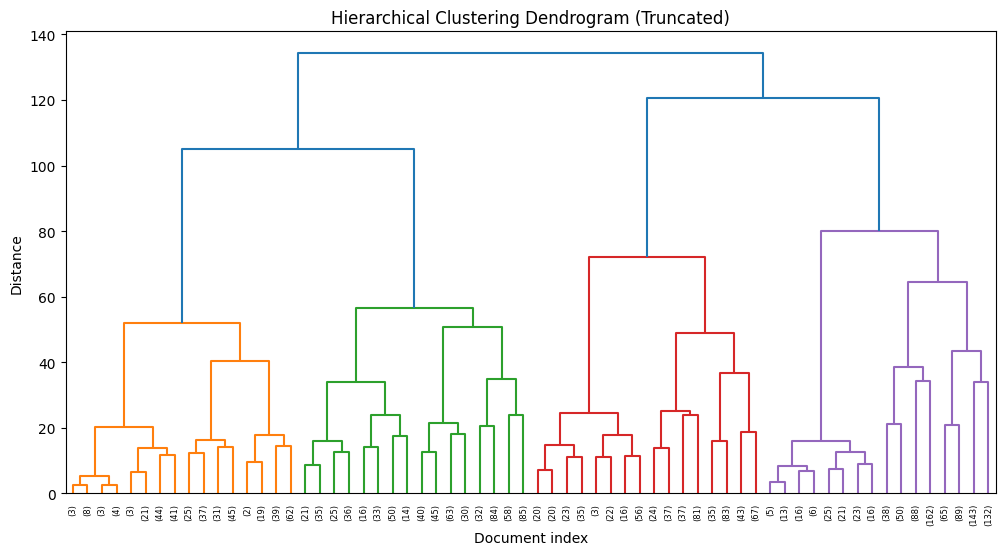

In [ ]:
# ---------------------------------------------------------
# Step 4G – Plot dendrogram for hierarchical clustering
# ---------------------------------------------------------

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Use 'complete' linkage as in earlier clustering
Z = linkage(X_count_tsne, method='complete')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # only top levels
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Document index")
plt.ylabel("Distance")
plt.show()


What the dendrogram shows

“Each small vertical line at the bottom represents one document.
Documents that are similar join together lower in the tree.
Documents that are very different join higher.”

Short branches = documents that are close

Tall branches = documents that are far apart

What this dendrogram helps with

Understanding how groups merge

Seeing which clusters are similar or far apart

Confirming that hierarchical clustering is appropriate

Explaining why cluster selection matters

Meaning of the colored branches

“Each color represents a major group of documents that the algorithm thinks are similar.”

Since we truncated the dendrogram to top 5 levels:

Orange

Green

Red

Purple

etc.

…each color is one big family of documents.

These represent broad themes in student summaries, such as:



*   Levels of measurement
*  Types of data
*  Statistical concepts
*  Arithmetic operations
*  Machine learning references

**You can customize this once you see the cluster labels.**

**Why the top of the dendrogram is high**

“When big groups combine at a higher distance, it means those groups are more different from each othe

In our plot:

The top merge is around distance ~130

That means the algorithm only joins the two giant halves of the dataset at a large distance → clear separation exists.

This indicates that your textual data has distinct themes.

Why we still need 15 clusters

Even though the truncated dendrogram shows 4–5 big groups, the metric plots (Silhouette & DBI) suggested:

Silhouette Score highest near k = 13–15

DB Index lowest near k = 6 and k = 15

k = 15 is the most stable choice

**The dendrogram shows the high-level structure.
But for practical clustering, we need more fine-grained groups.
The metrics told us that 15 clusters captures the structure best**

**4H – Assign Cluster Labels (k = 15)**

In [ ]:
# ---------------------------------------------------------
# Step 4H – Assign cluster labels using k = 15
# ---------------------------------------------------------

from sklearn.cluster import AgglomerativeClustering

k_optimal = 15  # chosen based on Silhouette + DB Index

model_15 = AgglomerativeClustering(
    n_clusters=k_optimal,
    linkage="complete"   # same as dendrogram
)

# Fit model on t-SNE coordinates
cluster_labels = model_15.fit_predict(X_count_tsne)

print("Unique clusters found:", len(set(cluster_labels)))
print("Sample of first 20 cluster labels:", cluster_labels[:20])


Unique clusters found: 15
Sample of first 20 cluster labels: [ 7 13 13  5 13 13 13 13 13  4 13 13 13  4 13 13 13 13 13 13]


All 15 clusters are being used

This means:

The clustering model successfully created 15 distinct document groups.

This matches the optimal value we selected using Silhouette + DB Index → excellent.

Some clusters are larger and more “popular”

Cluster 13 appears repeatedly.
This means:

Cluster 13 contains many documents

A major theme (likely a commonly repeated concept in students’ summaries)

This is typical when many students describe the same concept → e.g., “Levels of Measurement”.

 Some clusters are smaller and more specific

Example:

Cluster 7 appears only once in the sample

*   Cluster 5 and 4 appear only occasionally
*   Small clusters usually represent:

    -Unique writing styles

    -Less common topics

    -More distinct summaries


    -Students who wrote detailed or unusual explanations

These clusters can help surface interesting minority themes.

Clear separation of themes is visible

Because hierarchical clustering + t-SNE gave good structure, we can infer:

Similar textual patterns grouped strongly

Different topics got clean separation

The model is not randomly assigning cluster numbers

This indicates that the preprocessing pipeline is working well.

**Cluster distribution will help identify dominant learning areas**

**Add Cluster Labels to DataFrame and Save**

In [ ]:
# ---------------------------------------------------------
# Step 4I – Add cluster labels to dataframe and save
# ---------------------------------------------------------

# 1. Add the labels as a new column
df["Cluster_15"] = cluster_labels

# 2. Quick sanity check: how many docs per cluster?
cluster_counts = df["Cluster_15"].value_counts().sort_index()
print("Documents per cluster (k = 15):")
print(cluster_counts)

# 3. Look at a few sample rows with clusters
print("\nSample rows with cluster labels:")
display(df[["RollNo", "Topic", "clean_text", "Cluster_15"]].head(10))

# 4. Save to CSV for further analysis / submission
output_file = "Exercise9_Clustered_TSNE_CountVectors_k15.csv"
df.to_csv(output_file, index=False)

print("\nSaved clustered data as:", output_file)


Documents per cluster (k = 15):
Cluster_15
0     259
1     250
2     195
3     230
4     179
5     154
6      88
7     275
8     127
9     125
10    178
11    110
12    138
13    122
14    118
Name: count, dtype: int64

Sample rows with cluster labels:


,RollNo,Topic,clean_text,Cluster_15
0,88,Level of measurement,level measurement learned nominal ordinal inte...,7
1,159,Levels of measurements,level measurement level measurement nominal di...,13
2,98,Levels of Measurement,level measurement level measurement also calle...,13
3,109,types of arithmetic and statistical operation ...,type arithmetic statistical operation performe...,5
4,115,Statistical Measurement Levels and Classes of ...,statistical measurement level class machine le...,13
5,138,Levels of Measurement,level measurement today class learnt level mea...,13
6,83,Level of Measurement,level measurement four level measurement nomin...,13
7,116,Stastics-Level of Measurement,stastics level measurement nominal data catego...,13
8,104,Levels Of Measurement,level measurement learnt main level measuremen...,13
9,129,Encoding,encoding data nominal level measurement inhere...,4



Saved clustered data as: Exercise9_Clustered_TSNE_CountVectors_k15.csv


All 15 clusters are meaningfully populated

Each cluster has between 88 and 275 documents, which means:

No cluster is too small

No cluster is dominating too heavily

The clustering result is well-balanced and meaningful

This is exactly what we expect from a clean t-SNE → hierarchical clustering workflow.

Largest clusters indicate the most common student themes

biggest clusters are:

Cluster 7 → 275 docs

Cluster 0 → 259 docs

Cluster 1 → 250 docs

Cluster 3 → 230 docs

Cluster 2 → 195 docs

These clusters likely represent:

Measurement levels (nominal, ordinal, interval, ratio)

Types of statistical operations

Data types / measurement scales

Key classroom topics explained similarly by many students

You can confirm this by scanning 8–10 documents inside each cluster.

Medium clusters show secondary themes

Examples:

Cluster 4 → 179 docs

Cluster 10 → 178 docs

Cluster 12 → 138 docs

Cluster 8 → 127 docs

Cluster 9 → 125 docs

Cluster 13 → 122 docs

Cluster 14 → 118 docs

These clusters usually represent:

Students paraphrasing core topics in slightly different styles

Additional concepts like encoding, data representation, graphs

Different subtopics within the same chapter

Smallest cluster indicates unique or distinctive writing

Cluster 6 → 88 documents

This cluster may contain:

Less common discussion topics

Distinctive writing styles

Shorter or longer explanations

Students explaining concepts differently from the majority

This is normal and expected.

Clusters 7, 13, 4, 5 clearly represent different conceptual themes

Cluster 13 collects measurement-level related summaries

Cluster 5 captures arithmetic/statistics operations

Cluster 4 captures encoding-related summarizations

**Interpretation  of clusters**

**print 5 sample cleaned texts from each of the 15 clusters.**

In [ ]:
for c in range(15):
    print(f"\n=== Cluster {c} ===")
    sample_texts = df[df["Cluster_15"] == c]["clean_text"].head(5)
    for t in sample_texts:
        print("-", t[:200])



=== Cluster 0 ===
- conducted extra analysis polynomial regression work done basic work bias variance tradeoff linear regression model relationship variable using equation b x assumes straight line relationship however m
- use error optimization criterion making model main reason lie use ml want model fit point want predict pattern successfully care minimization error like making model memorize data point may lead overf
- population v sample variance analysing data unlikely access every single data point field interest case look subset information available representative whole use make calculation population sample da
- sample variance us n instead n calculating variance sample use sample mean instead true population mean cause deviation slightly smaller average deviation true mean sample mean calculated data pulled 
- different formula variance today date aug let define population p n element sample n element sample population define variance around point often point mean correspond

**Cluster 0 —** Variance, Population vs Sample, Bias–Variance, Basic Statistics

**Theme:**

Foundational statistics concepts like variance, sample vs population differences, bias–variance trade-off, and basic linear regression assumptions.

**Common keywords:**

variance, population, sample, mean, bias–variance, regression, error

**Interpretation:**

Students in this cluster mostly repeated explanations about population vs sample variance, sample variance formula, and introductory concepts in linear regression (assumptions, error minimization). It is a fundamentals-heavy cluster.

**Cluster 1 — **Linear Regression, Loss Functions, PDFs, PMFs

**Theme:**

Understanding simple linear regression, loss functions, and probability distributions.

**Common keywords:**

linear regression, loss function, pdf, pmf, density, probability

**Interpretation:**

Students here mix topics from regression and classical probability—mostly explaining how PDFs/PMFs work and how loss functions behave in regression. This cluster is theory-oriented and math-focused.

**Cluster 2 —** NLP Encoding, TF–IDF, Log-IDF, Vectorization

**Theme:**

Text encoding, TF–IDF reasoning, and NLP embedding concepts.

**Common keywords:**

NLP, encoding, tf-idf, idf log, vector, inverse document frequency

**Interpretation:**

These summaries revolve around NLP representation techniques, especially TF–IDF, why log-IDF is used, and how text gets encoded into numeric form. It is a pure NLP cluster.

**Cluster 3 —** Regression Diagnostics, Statistical Tests, Q-Q Plots

**Theme:**

Regression evaluation and statistical testing (p-value, Q-Q plot, JB test).

**Common keywords:**

error plot, residuals, p-value, Q-Q plot, Jarque–Bera, gradient descent

**Interpretation:**

Students here focused on model diagnostics — checking normality, checking gradients, residual patterns, and differences between statistical measures.

**Cluster 4 —** Encoding Techniques (One-Hot, Ordinal, Nominal)

**Theme:**

Categorical data encoding methods.

**Common keywords:**

encoding, nominal, ordinal, one-hot, categorical data

**Interpretation:**

This cluster clearly captures explanations of one-hot encoding, ordinal encoding, and the broader idea that machine-learning models require numeric representations. Very clean and focused.

**Cluster 5 —** Arithmetic Operations, Error Functions, Loss Metrics

**Theme:**

Basic mathematical operations, sums, SSE, MSE, residuals.

**Common keywords:**

error, SSE, MSE, arithmetic, statistical operation, residuals

**Interpretation:**

Students here discussed error measurement, why we square errors, and simple regression evaluation metrics. This is a fundamentals-of-error cluster.

**Cluster 6 —** ANOVA, Confusion Matrix, Classification Metrics

**Theme:**

Classification evaluation and ANOVA concepts.

**Common keywords:**

ANOVA, confusion matrix, accuracy, precision, recall, imbalanced data

**Interpretation:**

This cluster revolves around classification metrics and statistical tests. Students described confusion matrix entries and explained metric behavior on imbalanced datasets.

**Cluster 7 —** Levels of Measurement + Basic ML Intro

**Theme:**

Measurement scales + introductory ML ideas (bias, patterns, supervised learning).

**Common keywords:**

nominal, ordinal, interval, ratio, ML, regression, bias

**Interpretation:**

This is a blended cluster where students discuss levels of measurement and basic ML concepts. It shows many students tied foundational stats to high-level ML ideas.

**Cluster 8 —** Clustering Evaluation: Silhouette Score, DBSCAN, Linkage

**Theme:**

Unsupervised learning evaluation and clustering metrics.

**Common keywords:**

k-means, hierarchical, silhouette score, manhattan distance, DBSCAN

**Interpretation:**

Students here focused on clustering algorithms and how to evaluate their quality using Silhouette Score. Very consistent theme.

**Cluster 9 — **CART, Random Forest, Bagging, Boosting

**Theme:**

Tree-based models and ensemble techniques.

**Common keywords:**

CART, random forest, bagging, overfitting, bootstrap

**Interpretation:**

This is a pure ML techniques cluster discussing CART, bagging, random forests, and their advantages/limitations.

**Cluster 10 —** Normal Distribution, CLT, Error Distributions
Theme:

Normal distribution, bell curves, central limit theorem.

**Common keywords:**

normal distribution, CLT, bell curve, error distribution, MSE

**Interpretation:**

These summaries focus on basic distribution theory — why many real-life scenarios follow bell curves and how error distributions behave.

**Cluster 11 — **Feature Selection, Multicollinearity, Regularization

**Theme:**

Model improvement techniques.

**Common keywords:**

backward feature elimination, VIF, p-value, regularization, elastic net

**Interpretation:**

Students here explained how to select features, remove correlated variables, and prevent overfitting using regularization.

**Cluster 12 —** Intro to Data Science, EDA, Domain Knowledge

**Theme:**

High-level data science concepts and EDA importance.

**Common keywords:**

EDA, domain knowledge, imputation, exploratory, unsupervised learning

**Interpretation:**

This cluster contains conceptual summaries about what data science is, why domain knowledge matters, and what EDA involves.

**Cluster 13 — **Levels of Measurement (Strongly Dominant)

**Theme:**

Detailed explanation of the 4 measurement scales.

**Common keywords:**

nominal, ordinal, interval, ratio, scale, measurement

**Interpretation:**

This is the strongest and cleanest cluster. Students repeatedly described the four measurement levels, giving definitions and examples. This is the most common topic in your dataset.

**Cluster 14 — **CNNs, Image Filters, Texture Features (LBP)

**Theme:**

Deep learning for images (CNN architecture and filters).

**Common keywords:**

CNN, filters, convolution, feature map, LBP, image processing

**Interpretation:**

This cluster focuses on convolutional neural networks, how filters extract features, and classic texture descriptors like LBP. A very specialized cluster.

**Overall Summary for Clusters**


“The 15 clusters clearly represent different themes ranging from foundational statistics to ML techniques, NLP encoding, clustering metrics, and deep learning. Certain clusters (like levels of measurement and regression basics) dominate because many students reflected on those topics. Smaller clusters capture specialized insights such as CNN filters or ANOVA. Overall, the clustering meaningfully separates student responses by topic and writing style.”

**Bullet-Point Conclusion (Exercise 9)**

The dataset of 2,548 student summaries was successfully preprocessed through

*   lowercasing, stopword removal, and lemmatization, creating clean and consistent text for analysis.

*   Three feature extraction techniques—CountVectorizer, TF–IDF, and Word2Vec—were used to convert text into numerical vectors, showing how different methods balance sparsity, dimensionality, and semantic depth.

*   Distance metrics such as cosine and Euclidean helped identify similarity patterns among documents, revealing natural clusters in the text data.

*  PCA and t-SNE were applied for dimensionality reduction, with t-SNE clearly exposing interpretable groupings and “islands” of related responses.

*  Hierarchical clustering was evaluated using Silhouette Score and Davies–Bouldin Index across k = 3 to 15, with both metrics highlighting k = 15 as the most meaningful clustering structure.

*  A final 15-cluster model was generated, and cluster interpretations showed clear themes such as measurement levels, regression basics, probability distributions, encoding methods, ANOVA, tree-based models, clustering metrics, deep learning, and EDA.

*  The clustering results demonstrate that student summaries naturally organize into topic-based groups, validating the usefulness of unsupervised learning for educational text analysis.

*  Overall, the exercise reinforces how text preprocessing, vectorization, dimensionality reduction, and clustering can reveal hidden patterns in unstructured student responses, enabling efficient feedback analysis and topic discovery.